# Ground state solvers - Tutorial


**December 02, 2022 <br/>**
**For NTU: Quantum Industry Day 2022 <br>**
This tutorial was generated from [Qiskit Nature docs: Ground state solvers](https://qiskit.org/documentation/nature/tutorials/03_ground_state_solvers.html)

## Introduction




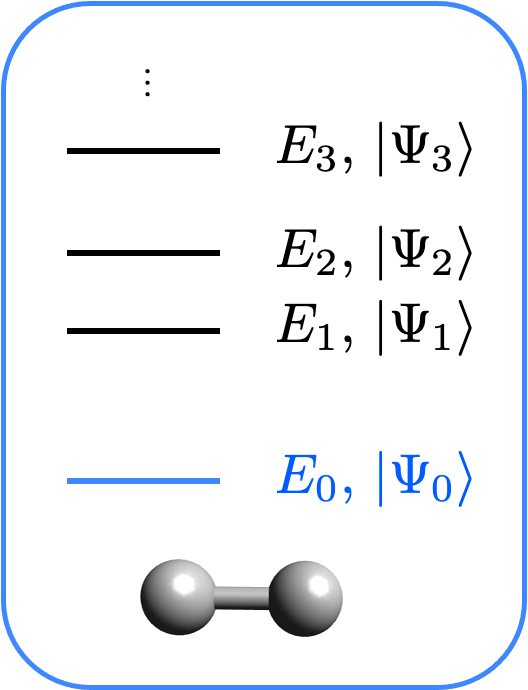


In this tutorial we are going to discuss the ground state calculation interface of Qiskit Nature. The goal is to compute the ground state of a molecular Hamiltonian. This Hamiltonian can for example be electronic or vibrational. To know more about the preparation of the Hamiltonian, check out the [Electronic structure](https://qiskit.org/documentation/nature/tutorials/01_electronic_structure.html) and [Vibrational structure tutorials](https://qiskit.org/documentation/nature/tutorials/02_vibrational_structure.html). 

> It should be said, that in the electronic case, we are actually computing purely the **electronic** part. When using the Qiskit Nature stack as presented in this tutorial, the _nuclear repulsion energy_ will be added automatically, to obtain the **total** ground state energy.

The first step is to define the molecular system. In the following we ask for the electronic part of a hydrogen molecule.

In [1]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run()

We will also be sticking to the Jordan-Wigner mapping. To learn more about the various mappers available in Qiskit Nature, check out the [Qubit Mappers tutorial](https://qiskit.org/documentation/nature/tutorials/06_qubit_mappers.html).

In [2]:
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter

converter = QubitConverter(JordanWignerMapper())

In [3]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(eval_count, parameters, mean, metadata):
    clear_output(wait=True)
    objective_func_vals.append(mean.real)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)),objective_func_vals)
    plt.show()

## The Solver

After these steps, we need to define a solver. The solver is the algorithm through which the ground state is computed. 

Let's first start with a purely classical example: the `NumPyMinimumEigensolver`. This algorithm exactly diagonalizes the Hamiltonian. Although it scales badly, it can be used on small systems to check the results of the quantum algorithms. 

In [4]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()

To find the ground state we could also use the Variational Quantum Eigensolver (VQE) algorithm. The VQE algorithm works by exchanging information between a classical and a quantum computer as depicted in the following figure.



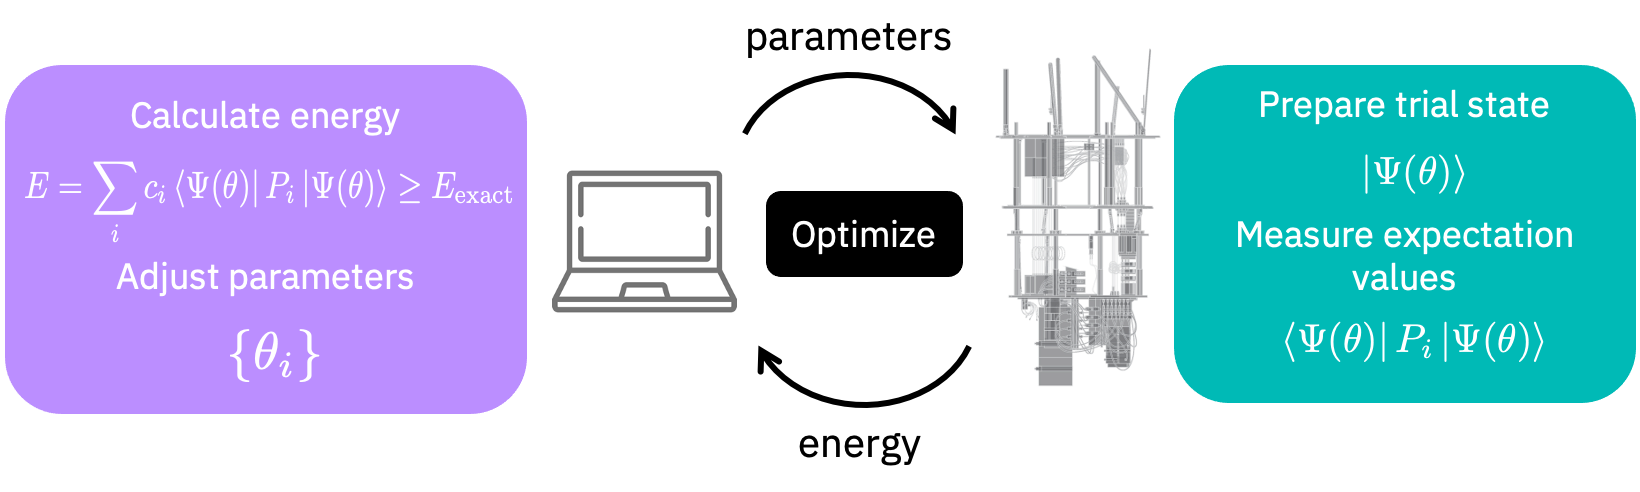


Let's initialize a VQE solver.

In [5]:
from qiskit.algorithms.optimizers import SLSQP, SPSA
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_nature.second_q.circuit.library import UCCSD
objective_func_vals = []


vqe_solver = VQEUCCFactory(estimator = Estimator(), 
                           ansatz = UCCSD(), 
                           optimizer = SPSA(),
                           callback=callback_graph)

## The calculation and results

We are now ready to put everything together to compute the ground-state of our problem.
Doing so requires us to wrap our `QubitConverter` and quantum algorithm into a single `GroundStateEigensolver` like so:

In [6]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

calc = GroundStateEigensolver(converter, vqe_solver)

This will now take of the entire workflow:
1. generating the second-quantized operators stored in our `problem`
2. mapping (and potentially reducing) the operators in the qubit space
3. if we provided a quantum algorithm factory (e.g. `VQEUCCFactory`): finalizing its setup based on the `problem`
4. running the quantum algorithm on the Hamiltonian qubit operator
5. once converged, evaluating the additional observables at the determined ground state

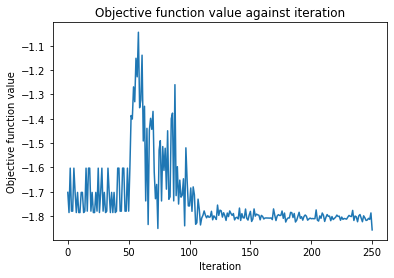

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857142778001
  - computed part:      -1.857142778001
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137173783552
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.41587755]
    - computed part:      [0.0  0.0  1.41587755]
  > Dipole moment (a.u.): [0.0  0.0  -0.02692885]  Total: 0.02692885
                 (debye): [0.0  0.0  -0.0684463]  Total: 0.0684463
 


In [7]:
res = calc.solve(es_problem)
print(res)

In [8]:
objective_1 = objective_func_vals
objective_func_vals = []

## Ansatz - UCCSD

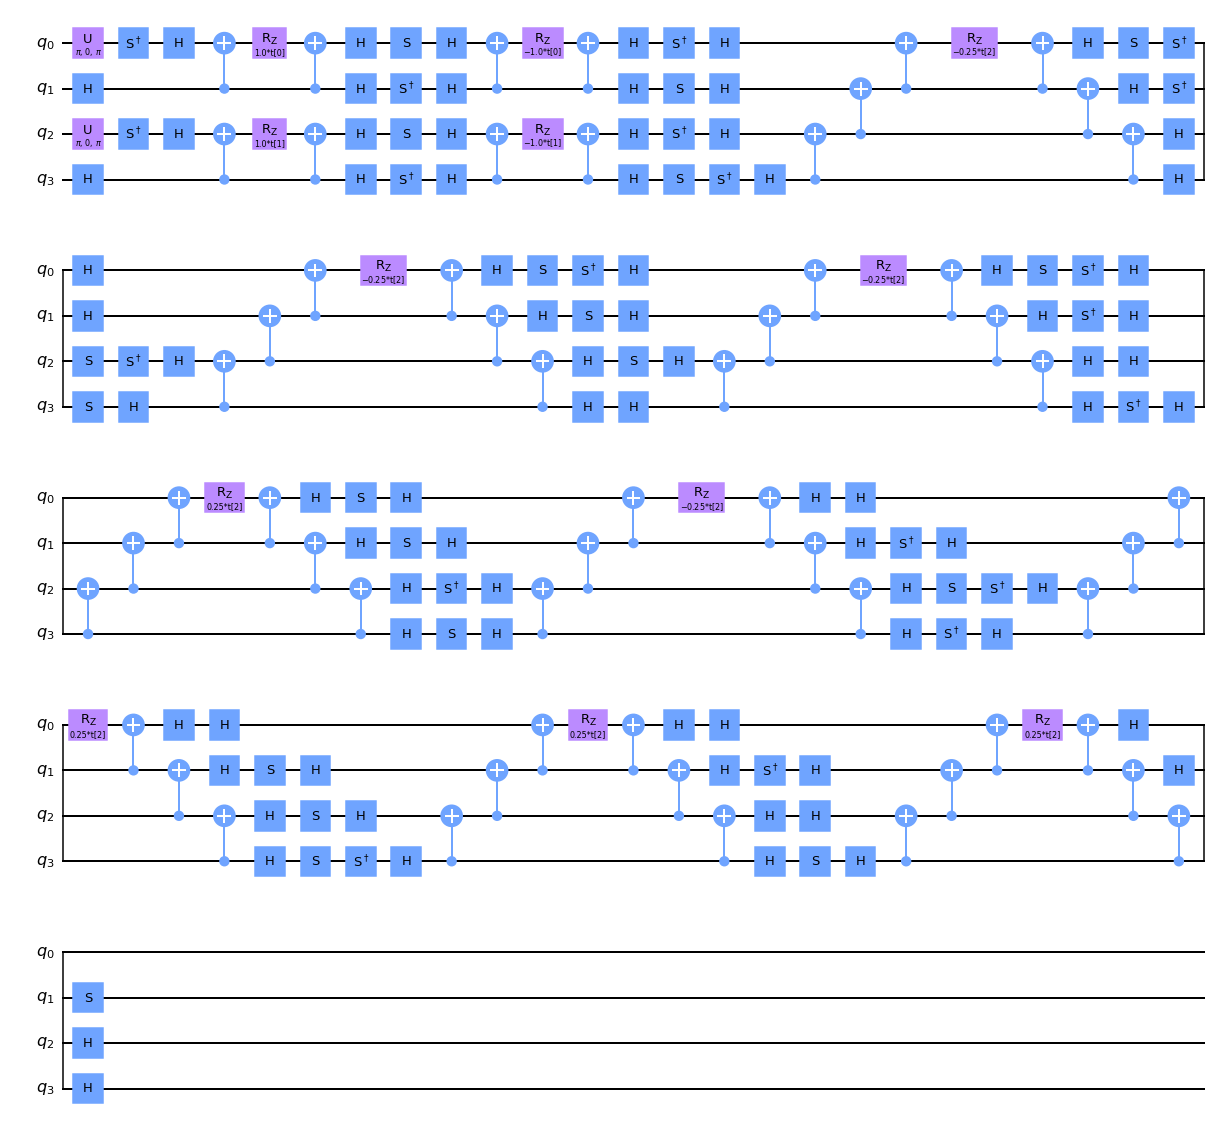

In [9]:
vqe_solver.ansatz.decompose().decompose().decompose().draw(output="mpl")

## Setting up on Qiskit Runtime
We shall get started with Qiskit Runtime. Qiskit Runtime is already installed and setup for you in the IBM Quantum Lab instance of the IBM Quantum Challenge you are in. To learn more about primitives, check out [this resource](https://qiskit.org/documentation/apidoc/primitives.html)

If you are running on your local systems, you may need to install Qiskit Runtime packages which can be dones uing: pip install qiskit-ibm-runtime. If you have navigated to the IBM Quantum Lab throught the IBM Quantum Challenge portal, then everything should already be setup for you.

To start off, the first thing to do here is to define QiskitRuntimeService instance to run the program on. We can use this to call the currently available two primitives as needed; Estimator and run them on Qiskit Runtime.

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator

The block below saves your Runtime account credentials for your current environment. The `channel` keyword argument lets the Runtime know whether you are using the regular IBM Quantum (`channel='ibm_quantum'`) or IBM Cloud (`channel='ibm_cloud'`). We will be using the `ibm_quantum` channel for all our runs. This cell can be run just once and your credentials should be saved for that environment. And for the `token` keyword argument, your API token value is found in this link: **[quantum-computing.ibm.com/account](https://quantum-computing.ibm.com/account)**.

If you are on the IBM Quantum Lab, you can simply call the `QiskitRuntimeService` with just the channel in your subsequent runs.

In [3]:
# Save the Runtime account credentials if you have not done so already
# If you need to overwrite the account info, please add `overwrite=True`
QiskitRuntimeService.save_account(channel='ibm_quantum', token='cc94126b0f0862e423b9a508b1293f7dafeb27791cf1a2b3c116c9ae34aec68f286f232657ff885284d5890a59c306e2df11885a8a79d574192c70220c0cf069', overwrite=True)

In [4]:
service = QiskitRuntimeService(channel='ibm_quantum')

Now that your service is setup, the service allows you to view all the backends that you have access to. Let's run the command below to display all the available backends that can utilize Qiskit Runtime.

In [ ]:
service.backends()

First, let's set a backend to use. We shall be running our routines on the `ibmq_qasm_simulator` on cloud.

In [ ]:
backend = service.backends(simulator=True)[0]
print(backend)

To define the VQE solver one needs three essential elements:

1. An Estimator primitive: these were released as part of Qiskit Terra 0.22. To learn more about primitives, check out [this resource](https://qiskit.org/documentation/apidoc/primitives.html).
2. A variational form: here we use the Unitary Coupled Cluster (UCC) ansatz (see for instance [Physical Review A 98.2 (2018): 022322]). Since it is a chemistry standard, a factory is already available allowing a fast initialization of a VQE with UCC. The default is to use all single and double excitations. However, the excitation type (S, D, SD) as well as other parameters can be selected. Since we are using the `VQEUCCFactory`, this will also prepend the `UCCSD` variational form with a `HartreeFock` initial state, which initializes the occupation of our qubits according to the problem which we are trying solve.
3. An optimizer: this is the classical piece of code in charge of optimizing the parameters in our variational form. See [the corresponding documentation of Qiskit Terra](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html) for more information.

One could also use any available ansatz / initial state or even define one's own. For instance,

In [ ]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import TwoLocal


tl_circuit = TwoLocal(
    rotation_blocks=["h", "rx"],
    entanglement_blocks="cz",
    entanglement="full",
    reps=2,
    parameter_prefix="y",
)

objective_func_vals = []

converter = QubitConverter(JordanWignerMapper())
qubit_op = converter.convert(es_problem.second_q_ops()[0])

with Session(service = service, backend = backend):
    another_solver = VQE(estimator = Estimator(),
                         ansatz = tl_circuit, 
                         optimizer = SPSA(maxiter=20),
                         callback=callback_graph)
    
    result = another_solver.compute_minimum_eigenvalue(qubit_op)   

In [ ]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator

tl_circuit = TwoLocal(
    rotation_blocks=["h", "rx"],
    entanglement_blocks="cz",
    entanglement="full",
    reps=2,
    parameter_prefix="y",
)

objective_func_vals = []

converter = QubitConverter(JordanWignerMapper())
qubit_op = converter.convert(es_problem.second_q_ops()[0])

with Session(service = service, backend = backend):
    another_solver = VQE(estimator = Estimator(),
                         ansatz = tl_circuit, 
                         optimizer = SPSA(maxiter=20),
                         callback=callback_graph)

In [65]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

calc_2 = GroundStateEigensolver(converter, another_solver)

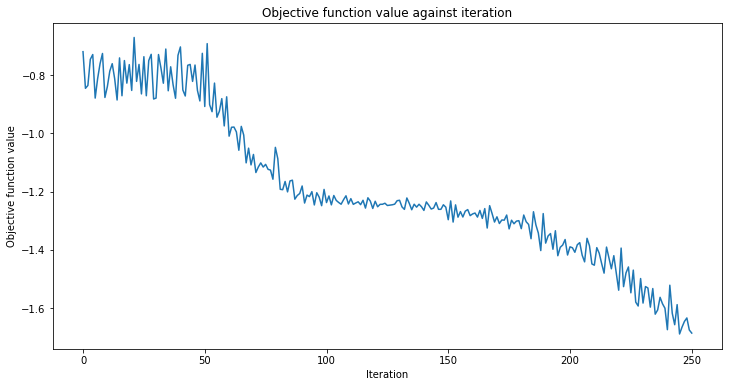

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.685867278252
  - computed part:      -1.685867278252
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -0.965898283804
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 1.859 S: 0.172 S^2: 0.201 M: -0.124
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.27847426]
    - computed part:      [0.0  0.0  1.27847426]
  > Dipole moment (a.u.): [0.0  0.0  0.11047444]  Total: 0.11047444
                 (debye): [0.0  0.0  0.28079799]  Total: 0.28079799
 


In [66]:
with Session(service=service, backend=backend):    
    res_2 = calc_2.solve(es_problem)
 
print(res_2)

In [67]:
objective_2 = objective_func_vals
objective_func_vals = []

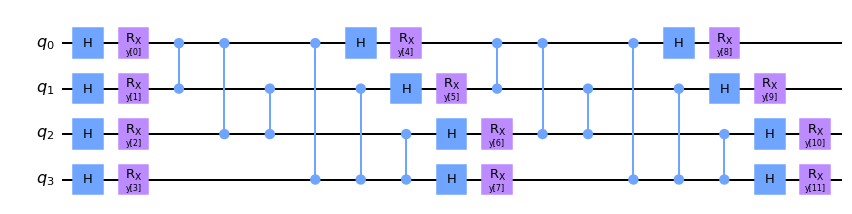

In [42]:
tl_circuit.decompose().draw(output="mpl")

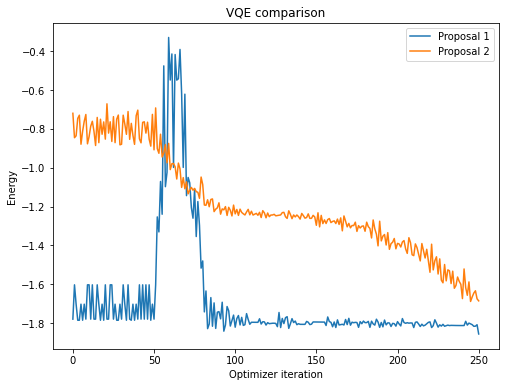

In [73]:
mean = [objective_1,objective_2]
plt.figure(figsize=(8, 6))
# Plot label
for value in range(len(mean)):
    plt.plot(mean[value], label="Proposal {}".format(value+1) )

plt.legend(loc="best")
plt.xlabel("Optimizer iteration")
plt.ylabel("Energy")

# Plot graph title
plt.title("VQE comparison".format(len(mean)))
plt.show()

We can compare the VQE results to the NumPy exact solver and see that they match. 

In [74]:
calc = GroundStateEigensolver(converter, numpy_solver)
res_ideal = calc.solve(es_problem)
print(res_ideal)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [75]:
print(f"Model     | Computed Ground state energy ")
print(f"----------------------------------------------------------")
print(f"Ideal     | {res_ideal.electronic_energies[0]} ")
print(f"----------------------------------------------------------")
print(f"UCCSD     | {res.electronic_energies[0]} ")
print(f"----------------------------------------------------------")
print(f"TwoLocal  | {res_2.electronic_energies[0]} ")
print(f"----------------------------------------------------------")


Model     | Computed Ground state energy 
----------------------------------------------------------
Ideal     | -1.857275030202376 
----------------------------------------------------------
UCCSD     | -1.8564584645115478 
----------------------------------------------------------
TwoLocal  | -1.6858672782524966 
----------------------------------------------------------


In [10]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright